<a href="https://colab.research.google.com/github/mochaheree/ecommerce-retention-analysis/blob/main/notebook/Customer_Segmentation_%26_Retention_Strategy_for_E_c.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
shriyashjagtap_e_commerce_customer_for_behavior_analysis_path = kagglehub.dataset_download('shriyashjagtap/e-commerce-customer-for-behavior-analysis')

print('Data source import complete.')


Using Colab cache for faster access to the 'e-commerce-customer-for-behavior-analysis' dataset.
Data source import complete.


In [10]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings

warnings.filterwarnings("ignore")

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/e-commerce-customer-for-behavior-analysis/.nfs00000000766f3a530000007b
/kaggle/input/e-commerce-customer-for-behavior-analysis/ecommerce_customer_data_large.csv
/kaggle/input/e-commerce-customer-for-behavior-analysis/ecommerce_customer_data_custom_ratios.csv


In [11]:
e_cust_l = pd.read_csv("/kaggle/input/e-commerce-customer-for-behavior-analysis/ecommerce_customer_data_large.csv")
e_cust_c = pd.read_csv("/kaggle/input/e-commerce-customer-for-behavior-analysis/ecommerce_customer_data_custom_ratios.csv")

# **CLEANING DATA**

In [12]:
e_cust_l.head()

,Customer ID,Purchase Date,Product Category,Product Price,Quantity,Total Purchase Amount,Payment Method,Customer Age,Returns,Customer Name,Age,Gender,Churn
0,44605,2023-05-03 21:30:02,Home,177,1,2427,PayPal,31,1.0,John Rivera,31,Female,0
1,44605,2021-05-16 13:57:44,Electronics,174,3,2448,PayPal,31,1.0,John Rivera,31,Female,0
2,44605,2020-07-13 06:16:57,Books,413,1,2345,Credit Card,31,1.0,John Rivera,31,Female,0
3,44605,2023-01-17 13:14:36,Electronics,396,3,937,Cash,31,0.0,John Rivera,31,Female,0
4,44605,2021-05-01 11:29:27,Books,259,4,2598,PayPal,31,1.0,John Rivera,31,Female,0


In [13]:
print("Missing values:\n", e_cust_l.isnull().sum())
print("\nDuplicates:", e_cust_l.duplicated().sum())
print("\nPurchase amount stats:\n", e_cust_l["Total Purchase Amount"].describe())


Missing values:
 Customer ID                  0
Purchase Date                0
Product Category             0
Product Price                0
Quantity                     0
Total Purchase Amount        0
Payment Method               0
Customer Age                 0
Returns                  47382
Customer Name                0
Age                          0
Gender                       0
Churn                        0
dtype: int64

Duplicates: 0

Purchase amount stats:
 count    250000.000000
mean       2725.385196
std        1442.576095
min         100.000000
25%        1476.000000
50%        2725.000000
75%        3975.000000
max        5350.000000
Name: Total Purchase Amount, dtype: float64


<Axes: >

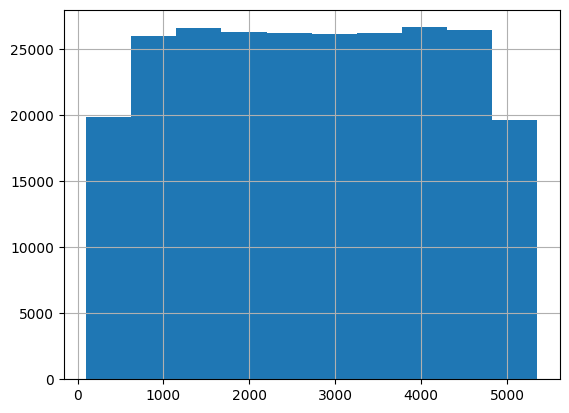

In [14]:
#Filling missing value on Returns
e_cust_l["Returns"] = e_cust_l["Returns"].fillna(0)
e_cust_l["Returns"] = e_cust_l["Returns"].astype(int)

#No Duplicate Rows

#Purchase amount stats
e_cust_l["Total Purchase Amount"].hist()

In [15]:
print("Missing values:\n", e_cust_l.isnull().sum())

Missing values:
 Customer ID              0
Purchase Date            0
Product Category         0
Product Price            0
Quantity                 0
Total Purchase Amount    0
Payment Method           0
Customer Age             0
Returns                  0
Customer Name            0
Age                      0
Gender                   0
Churn                    0
dtype: int64


So far this is good datasheet, only Returns have 47k missing value and we fill it with 0 as customer not return.
Zero duplicate data, and no extreme outliner on Total Purchase Amount.

In [16]:
e_cust_l.describe()

,Customer ID,Product Price,Quantity,Total Purchase Amount,Customer Age,Returns,Age,Churn
count,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.00000
mean,25017.632092,254.742724,3.004936,2725.385196,43.798276,0.405904,43.798276,0.20052
std,14412.515718,141.738104,1.414737,1442.576095,15.364915,0.491067,15.364915,0.40039
min,1.000000,10.000000,1.000000,100.000000,18.000000,0.000000,18.000000,0.00000
25%,12590.000000,132.000000,2.000000,1476.000000,30.000000,0.000000,30.000000,0.00000
50%,25011.000000,255.000000,3.000000,2725.000000,44.000000,0.000000,44.000000,0.00000
75%,37441.250000,377.000000,4.000000,3975.000000,57.000000,1.000000,57.000000,0.00000
max,50000.000000,500.000000,5.000000,5350.000000,70.000000,1.000000,70.000000,1.00000


# **Create New Datasheet**
Customer-level

In [17]:
e_cust_l["Purchase Date"] = pd.to_datetime(e_cust_l["Purchase Date"])

analysis_date = e_cust_l["Purchase Date"].max() + pd.Timedelta(days=1)

df = (
    e_cust_l
    .groupby("Customer ID")
    .agg(
        transaction_count=("Purchase Date", "count"),
        total_spend=("Total Purchase Amount", "sum"),
        avg_order_value=("Total Purchase Amount", "mean"),
        first_purchase_date=("Purchase Date", "min"),
        last_purchase_date=("Purchase Date", "max"),
        return_count=("Returns", "sum"),
        churn_flag=("Churn", "max")
        )
    .reset_index()
    .rename(columns={"Customer ID": "customer_id", "transaction_count":"frequency", "total_spend":"monetary"})
)
df["avg_order_value"] = df["avg_order_value"].round(2)
df["recency"]=(analysis_date - df["last_purchase_date"]).dt.days
df["tenure_days"] = (analysis_date - df["first_purchase_date"]).dt.days


df

,customer_id,frequency,monetary,avg_order_value,first_purchase_date,last_purchase_date,return_count,churn_flag,recency,tenure_days
0,1,3,6290,2096.67,2020-03-04 10:26:02,2022-11-29 06:48:25,0,0,289,1289
1,2,6,16481,2746.83,2020-07-31 16:27:41,2023-07-03 17:26:19,4,0,73,1140
2,3,4,9423,2355.75,2020-01-19 00:03:00,2023-02-03 03:58:07,0,0,223,1334
3,4,5,7826,1565.20,2020-10-12 22:03:10,2022-06-29 03:41:09,3,0,442,1066
4,5,5,9769,1953.80,2020-04-08 21:57:19,2022-07-16 04:08:09,3,0,425,1253
...,...,...,...,...,...,...,...,...,...,...
49656,49996,7,24034,3433.43,2020-09-05 07:32:48,2022-09-19 00:20:18,2,0,360,1104
49657,49997,2,5714,2857.00,2021-07-22 19:03:00,2022-08-21 12:46:16,0,0,389,783
49658,49998,10,20495,2049.50,2020-05-01 10:59:19,2023-08-31 11:32:30,6,1,14,1231
49659,49999,6,14321,2386.83,2020-07-23 06:56:05,2022-09-22 15:46:41,3,0,357,1148


In [18]:
#RFM Segmentation

df["R_score"] = pd.qcut(df["recency"], 5, labels=[5,4,3,2,1])
df["F_score"] = pd.qcut(df["frequency"], 5, labels=[1,2,3,4,5])
df["M_score"] = pd.qcut(df["monetary"], 5, labels=[1,2,3,4,5])
df["RFM_segment"] = (
    df["R_score"].astype(str) +
    df["F_score"].astype(str) +
    df["M_score"].astype(str)
)

df

,customer_id,frequency,monetary,avg_order_value,first_purchase_date,last_purchase_date,return_count,churn_flag,recency,tenure_days,R_score,F_score,M_score,RFM_segment
0,1,3,6290,2096.67,2020-03-04 10:26:02,2022-11-29 06:48:25,0,0,289,1289,2,1,1,211
1,2,6,16481,2746.83,2020-07-31 16:27:41,2023-07-03 17:26:19,4,0,73,1140,4,4,4,444
2,3,4,9423,2355.75,2020-01-19 00:03:00,2023-02-03 03:58:07,0,0,223,1334,3,2,2,322
3,4,5,7826,1565.20,2020-10-12 22:03:10,2022-06-29 03:41:09,3,0,442,1066,1,3,2,132
4,5,5,9769,1953.80,2020-04-08 21:57:19,2022-07-16 04:08:09,3,0,425,1253,2,3,2,232
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49656,49996,7,24034,3433.43,2020-09-05 07:32:48,2022-09-19 00:20:18,2,0,360,1104,2,4,5,245
49657,49997,2,5714,2857.00,2021-07-22 19:03:00,2022-08-21 12:46:16,0,0,389,783,2,1,1,211
49658,49998,10,20495,2049.50,2020-05-01 10:59:19,2023-08-31 11:32:30,6,1,14,1231,5,5,5,555
49659,49999,6,14321,2386.83,2020-07-23 06:56:05,2022-09-22 15:46:41,3,0,357,1148,2,4,3,243


In [19]:
#Customer who repeat transaction

df["is_repeat"] = df["frequency"] > 1

rep = df.groupby("is_repeat").agg(
        customers_count=("customer_id", "count"),
        revenue_total=("monetary", "sum")
    )

rep["cust_pct"] = (rep["customers_count"]/rep["customers_count"].sum() * 100).round(2)
rep["revenue_pct"] = (rep["revenue_total"]/rep["revenue_total"].sum() * 100).round(2)

rep

,customers_count,revenue_total,cust_pct,revenue_pct
is_repeat,,,,
False,1653,4537566,3.33,0.67
True,48008,676808733,96.67,99.33


In [20]:
#Pareto Check

df_sorted = df.sort_values("monetary", ascending=False)

top_20 = int(len(df_sorted)*0.2)

rev_top20 = df_sorted.head(top_20)["monetary"].sum()
rev_tot = df_sorted["monetary"].sum()

rev_share = rev_top20/rev_tot * 100

print("Pareto Pct:", round(rev_share, 2))


Pareto Pct: 34.96


In [23]:
#TOP 20% as VIP Customer
df["is_vip"] = df["monetary"] >= df["monetary"].quantile(0.8)

vvip = df.groupby("is_vip").agg(
        avg_f=("frequency", "mean"),
        avg_r=("recency", "mean"),
        avg_m=("monetary", "mean"),
        avg_aov=("avg_order_value", "mean")
    )

vvip

,avg_f,avg_r,avg_m,avg_aov
is_vip,,,,
False,4.318239,288.348344,11153.907320,2634.737066
True,7.897413,158.293970,23983.073492,3096.474048


In [24]:
df["is_vip"] = df["is_vip"].astype(int)
df["is_repeat"] = df["is_repeat"].astype(int)


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49661 entries, 0 to 49660
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   customer_id          49661 non-null  int64         
 1   frequency            49661 non-null  int64         
 2   monetary             49661 non-null  int64         
 3   avg_order_value      49661 non-null  float64       
 4   first_purchase_date  49661 non-null  datetime64[ns]
 5   last_purchase_date   49661 non-null  datetime64[ns]
 6   return_count         49661 non-null  int64         
 7   churn_flag           49661 non-null  int64         
 8   recency              49661 non-null  int64         
 9   tenure_days          49661 non-null  int64         
 10  R_score              49661 non-null  category      
 11  F_score              49661 non-null  category      
 12  M_score              49661 non-null  category      
 13  RFM_segment          49661 non-

In [30]:
df

,customer_id,frequency,monetary,avg_order_value,first_purchase_date,last_purchase_date,return_count,churn_flag,recency,tenure_days,R_score,F_score,M_score,RFM_segment,is_repeat,is_vip
0,1,3,6290,2096.67,2020-03-04 10:26:02,2022-11-29 06:48:25,0,0,289,1289,2,1,1,211,1,0
1,2,6,16481,2746.83,2020-07-31 16:27:41,2023-07-03 17:26:19,4,0,73,1140,4,4,4,444,1,0
2,3,4,9423,2355.75,2020-01-19 00:03:00,2023-02-03 03:58:07,0,0,223,1334,3,2,2,322,1,0
3,4,5,7826,1565.20,2020-10-12 22:03:10,2022-06-29 03:41:09,3,0,442,1066,1,3,2,132,1,0
4,5,5,9769,1953.80,2020-04-08 21:57:19,2022-07-16 04:08:09,3,0,425,1253,2,3,2,232,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49656,49996,7,24034,3433.43,2020-09-05 07:32:48,2022-09-19 00:20:18,2,0,360,1104,2,4,5,245,1,1
49657,49997,2,5714,2857.00,2021-07-22 19:03:00,2022-08-21 12:46:16,0,0,389,783,2,1,1,211,1,0
49658,49998,10,20495,2049.50,2020-05-01 10:59:19,2023-08-31 11:32:30,6,1,14,1231,5,5,5,555,1,1
49659,49999,6,14321,2386.83,2020-07-23 06:56:05,2022-09-22 15:46:41,3,0,357,1148,2,4,3,243,1,0


In [26]:
df.to_csv('customer_dashboard_dataset.csv', index=False)
e_cust_l.to_csv('transaction_clean_dataset.csv', index=False)

print('DataFrames exported successfully!')

DataFrames exported successfully!
